In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from qiskit import(QuantumCircuit, QuantumRegister, ClassicalRegister, transpile)
from qiskit.visualization import plot_histogram, plot_gate_map
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import QFT
from qiskit_aer import AerSimulator

from qiskit_ibm_provider import IBMProvider
plt.style.use('default')


# Noisy simulations and Advanced Algorithms

## Local Aer simulations

In [9]:
#IBMProvider.save_account('f50aad64d3797ba40235a7cc83f315944b2cbbc3baab0b9835226d2031bf4670d96f1c3a0bf49555a49dbb8e83d8e0b46b2f6c7d0353f3dc55122ce5851b1703',overwrite=True) 
provider = IBMProvider(instance="ibm-q/open/main")

In [3]:
print(provider.backends(min_num_qubits=5, simulator=False, operational=True))

[<IBMBackend('ibm_lagos')>, <IBMBackend('ibm_perth')>, <IBMBackend('ibm_nairobi')>, <IBMBackend('ibm_brisbane')>]


In [9]:
print(provider.backends(min_num_qubits=5, simulator=True, operational=True))

[<IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('simulator_mps')>, <IBMBackend('simulator_statevector')>, <IBMBackend('simulator_stabilizer')>]


In [10]:
backend = provider.get_backend("ibm_lagos")

In [11]:
backend.status()

In [12]:
props = backend.properties()

In [18]:

def describe_qubit(qubit, properties):
    """Print a string describing some of reported properties of the given qubit."""

    # Conversion factors from standard SI units
    us = 1e6
    ns = 1e9
    GHz = 1e-9

    print("Qubit {0} has a \n"
          "  - T1 time of {1} microseconds\n"
          "  - T2 time of {2} microseconds\n"
          "  - U2 gate error of {3}\n"
          "  - U2 gate duration of {4} nanoseconds\n"
          "  - resonant frequency of {5} GHz".format(
              qubit,
              properties.t1(qubit) * us,
              properties.t2(qubit) * us,
              properties.gate_error('x', qubit),
              properties.gate_length('x', qubit) * ns,
              properties.frequency(qubit) * GHz))

describe_qubit(0, props)

Qubit 0 has a 
  - T1 time of 133.71983126826706 microseconds
  - T2 time of 44.69880459309118 microseconds
  - U2 gate error of 0.00018464390265061518
  - U2 gate duration of 35.55555555555556 nanoseconds
  - resonant frequency of 5.23535689369002 GHz


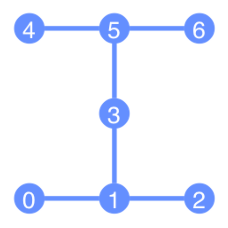

In [14]:
plot_gate_map(backend)

In [15]:
simulator = AerSimulator()
backendSimulator =  AerSimulator.from_backend(backend)

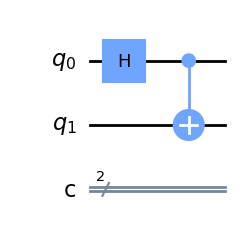

In [17]:
qr = QuantumRegister(2, 'q')
cr = ClassicalRegister(2, 'c')
circuit = QuantumCircuit(qr, cr,name="bell state")
circuit.h(0)
circuit.cx(0,1)
circuit.draw('mpl')

### State vector

In [19]:
vector=Statevector(circuit)
display(vector.draw('latex'))

<IPython.core.display.Latex object>

### Noiseless simulation

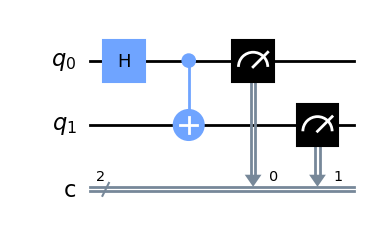

In [21]:
circuit = QuantumCircuit(qr, cr,name="bell state")
circuit.h(0)
circuit.cx(0,1)
circuit.measure([0,1],[0,1])
circuit.draw('mpl')

In [22]:
counts=simulator.run(circuit,shots=1000).result().get_counts()

{'00': 493, '11': 507}

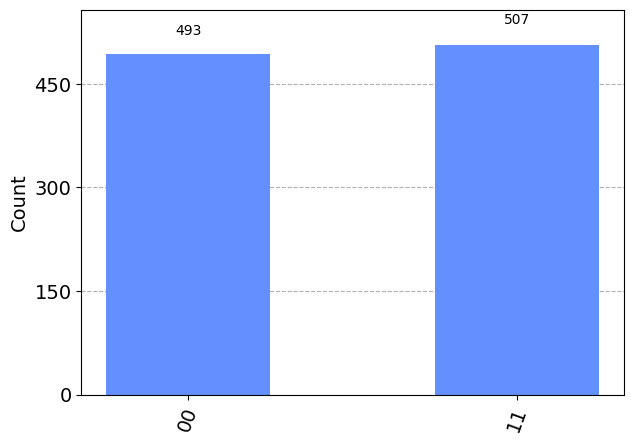

In [23]:
display(counts)
plot_histogram(counts)

### Noisy simulation

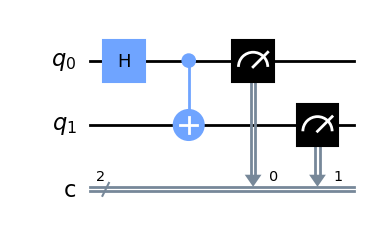

In [24]:
circuit = QuantumCircuit(qr, cr,name="bell state")
circuit.h(0)
circuit.cx(0,1)
circuit.measure([0,1],[0,1])
circuit.draw('mpl')

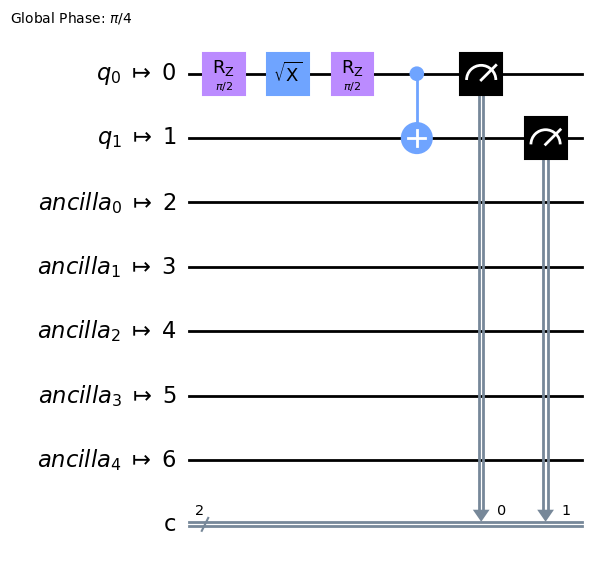

In [25]:
layout=[0,1]
circuitTranspiled=transpile(circuit,backendSimulator,initial_layout=layout,optimization_level=1)
circuitTranspiled.draw('mpl')

In [26]:
counts=backendSimulator.run(circuitTranspiled,shots=1000).result().get_counts()

{'01': 21, '10': 17, '00': 477, '11': 485}

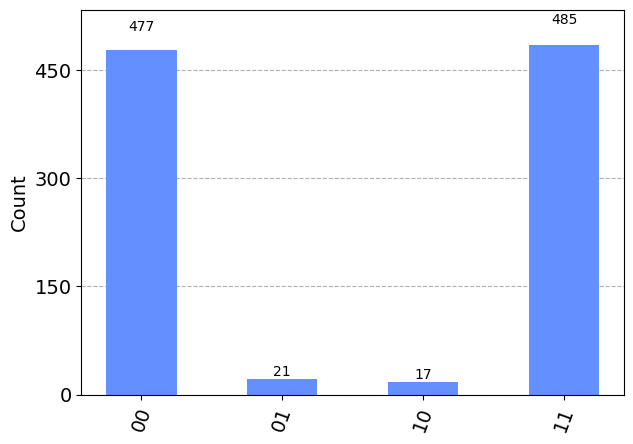

In [27]:
display(counts)
plot_histogram(counts)

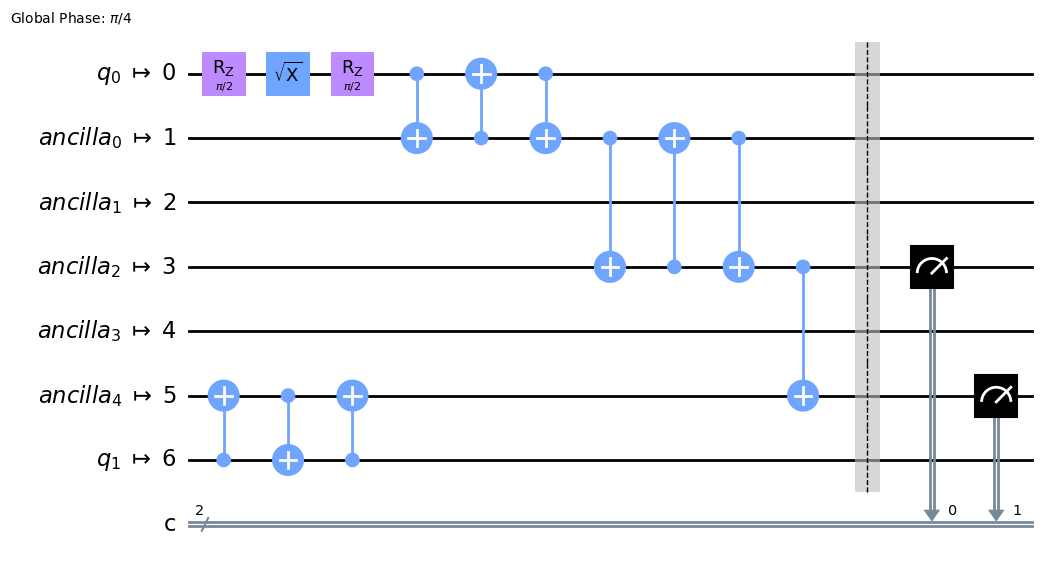

In [28]:
layout=[0,6]
circuitTranspiled=transpile(circuit,backendSimulator,initial_layout=layout,optimization_level=1)
circuitTranspiled.draw('mpl')

In [29]:
counts=backendSimulator.run(circuitTranspiled,shots=1000).result().get_counts()

{'01': 20, '10': 23, '00': 505, '11': 452}

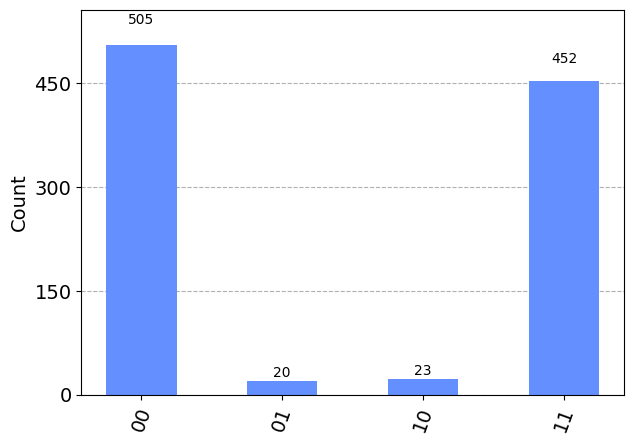

In [30]:
display(counts)
plot_histogram(counts)

## Sampler

In this tutorial we will show you how to set up the Qiskit Runtime `Sampler` primitive and explore the different options you can use to configure it.

[Primitives](https://qiskit.org/ecosystem/ibm-runtime/primitives.html) are core functions that make it easier to build modular algorithms and applications. 

The initial release of Qiskit Runtime includes two primitives:

**Sampler:** Generates quasi-probability distribution from input circuits.

**Estimator:** Calculates expectation values from input circuits and observables.

Similar to the `Backend` base class, there is an `Sampler` base class defined in Qiskit Terra that standardizes the way users interact with all `Sampler` implementations.
This allows users to easily change their choice of simulator or device for performing expectation value calculations, even if the underlying implementation is different. 

In this section we will be using the Qiskit Runtime's implementation of the `Sampler` primitive.

### 1. Initialize a Sampler class

Since Qiskit Runtime `Sampler` is a managed service, you will first need to initialize your account. You can then select the simulator or real backend you want to use to calculate the expectation value.

In [31]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("ibmq_qasm_simulator")

#backend = provider.get_backend("ibmq_qasm_simulator")

### 2. Create a circuit

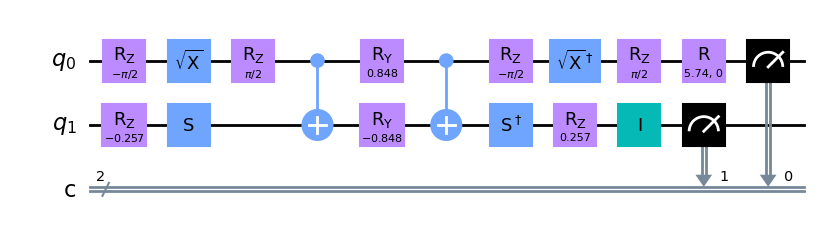

In [32]:
from qiskit.circuit.random import random_circuit

circuit = random_circuit(2, 2, seed=0, measure=True).decompose(reps=1)
circuit.draw("mpl")

### 3. Initialize the Qiskit Runtime Sampler

Here we are initializing an instance of `qiskit_ibm_runtime.Sampler` rather than `qiskit.primitives.Sampler` to use Qiskit Runtime's implementation of the `Sampler`. 

When you initialize the `Sampler`, you'll need to pass in the backend you previously selected as the target device (or simulator), using the `backend` parameter.

In [33]:
from qiskit_ibm_runtime import Sampler

sampler = Sampler(backend=backend)

#from qiskit.primitives import Sampler

#sampler = Sampler()

### 4. Invoke the Sampler and get results

You can then invoke the `run()` method to generate a quasi-probability distribution for the input circuit(s) and quantum state(s).

In [34]:
job = sampler.run(circuit)

In [39]:
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: clb5haipen43j46idc20
>>> Job Status: JobStatus.DONE


In [40]:
result = job.result()
print(f">>> {result}")
print(f"  > Quasi-probability distribution: {result.quasi_dists[0]}")
print(f"  > Metadata: {result.metadata[0]}")

>>> SamplerResult(quasi_dists=[{1: 0.03125, 2: 0.036, 0: 0.40675, 3: 0.526}], metadata=[{'shots': 4000, 'circuit_metadata': {}}])
  > Quasi-probability distribution: {1: 0.03125, 2: 0.036, 0: 0.40675, 3: 0.526}
  > Metadata: {'shots': 4000, 'circuit_metadata': {}}


### 5. Options

Primitives come with several options that are grouped into different categories. Commonly used options, such as `resilience_level`, are at the first level.


You can use the [Options](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/stubs/qiskit_ibm_runtime.options.Options.html#qiskit_ibm_runtime.options.Options) class to specify different options.

In the following example, we create an instance of the `Options` class. `optimization_level` is a first level option and can be passed as an input parameter. Options related to the execution environment are passed using the `environment` parameter.

In [41]:
from qiskit_ibm_runtime import Options

options = Options()
options.optimization_level = 1
options.execution.shots = 2048

When creating an instance of the `Sampler` class, you can pass in the `options` you just created. Those options will then be applied when you use `run()` to perform the calculation. 

In [42]:
sampler = Sampler(backend=backend, options=options)
job=sampler.run(circuit)

In [47]:
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: clb5hfk46cn44kd9ssvg
>>> Job Status: JobStatus.DONE


In [48]:
result = job.result()

In [51]:
print(f">>> Metadata: {result.metadata[0]}")

>>> Metadata: {'shots': 2048, 'circuit_metadata': {}}


### 6. Noisy simulations

In [52]:
from qiskit_aer.noise import NoiseModel
device = provider.get_backend("ibm_lagos")
noise_model = NoiseModel.from_backend(device)
coupling_map = device.configuration().coupling_map
basis_gates=device.configuration().basis_gates


In [53]:
options_with_nm = Options()
options_with_nm.simulator = {
    "noise_model": noise_model,
    "basis_gates": basis_gates,
    "coupling_map": coupling_map,
    "seed_simulator": 42
}

# Set number of shots, optimization_level and resilience_level
options_with_nm.execution.shots = 1000
options_with_nm.optimization_level = 0 # no optimization
options_with_nm.resilience_level = 1 # M3 for Sampler and T-REx for Estimator

In [54]:
sampler = Sampler(backend=backend, options=options_with_nm)
job = sampler.run(circuit)

In [56]:
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: clb5hnjk8l5ohotevih0
>>> Job Status: JobStatus.DONE


  > Quasi-probability distribution: {0: 0.390849005835994, 1: 0.049928496231831, 2: 0.058864948230833, 3: 0.500357549701342}


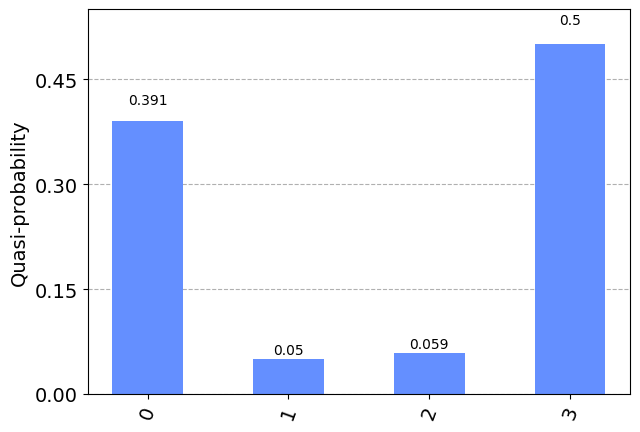

In [57]:
result=job.result()
print(f"  > Quasi-probability distribution: {result.quasi_dists[0]}")
plot_histogram(result.quasi_dists[0])

## Example: T1 & T2

In [58]:
circuitList=[]

for t in np.linspace(0,10000,101):
    circuit = QuantumCircuit(1, 1)
    circuit.x(0)
    #circuit.h(0) 
    circuit.barrier()
    for i in range(int(t)):
        circuit.id(0)
        circuit.barrier()
    #circuit.h(0)
    circuit.measure(0,0)
    circuitList.append(circuit)
   
circuitListTranspiled=transpile(circuitList,backendSimulator,initial_layout=[0],optimization_level=0)

In [59]:
countsList=backendSimulator.run(circuitListTranspiled,shots=1000).result().get_counts()

In [60]:
probabiltyVec=[]
for counts in countsList:
    probabiltyVec.append(counts.get('1')/1000)

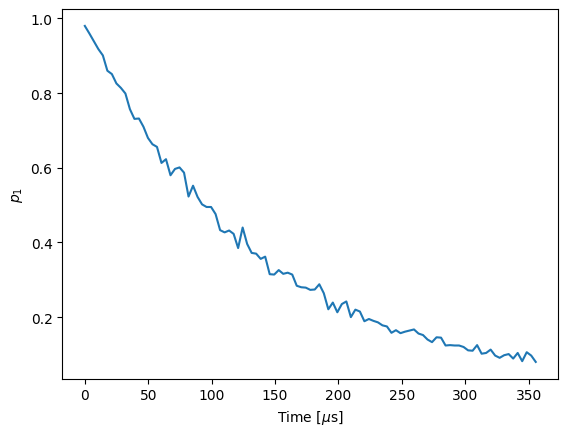

In [61]:
timeVec=np.linspace(0,10000,101)* props.gate_length('id', 0)   *10**6
plt.plot(timeVec,probabiltyVec)
plt.xlabel('Time [$\mu$s]')
plt.ylabel('$p_1$')
plt.show()

Let's fit this curve with an exponential function:
$$f(t)= A e^{-t/ \tau} + c$$

In [62]:
def func(x, amp, tau,c):
    return amp* np.exp(-x/tau)+c

In [63]:
popt, pcov = curve_fit(func, timeVec, probabiltyVec) # scipy's curve fitting tool
print(popt)

[9.75551347e-01 1.33329573e+02 1.57409488e-02]


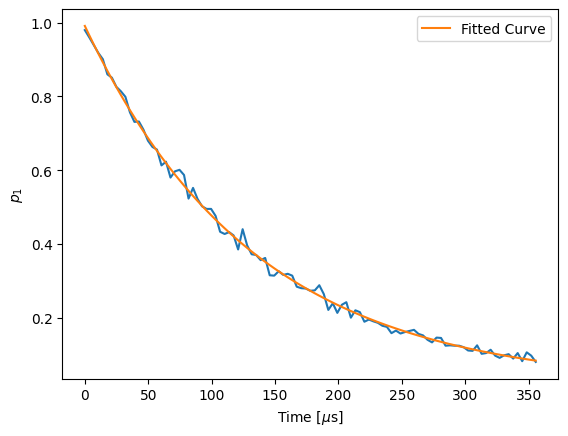

In [64]:
plt.plot(timeVec,probabiltyVec)
plt.plot(timeVec, func(timeVec, *popt), label="Fitted Curve") 
plt.xlabel('Time [$\mu$s]')
plt.ylabel('$p_1$')
plt.legend()
plt.show()

# Advanced algorithms

The Quantum Fourier Transform (QFT) is a fundamental component of several quantum algorithms. Some of the notable quantum algorithms that leverage the Quantum Fourier Transform include:

1. __Shor's Algorithm__: Shor's algorithm is a quantum algorithm that __efficiently factors large integers__. It plays a significant role in breaking widely used public-key cryptosystems such as RSA. The Quantum Fourier Transform is a crucial step in Shor's algorithm for finding the period of a function, which is essential for factoring large numbers.

2. __Quantum Phase Estimation__ (QPE): Quantum Phase Estimation is a quantum algorithm that provides an exponential speedup over its classical counterparts for certain problems. It's often used as a subroutine in other quantum algorithms. QPE uses the Quantum Fourier Transform to __estimate the eigenvalues of unitary operators__, which has applications in quantum simulations and solving certain types of problems.

3. The __HHL__ algorithm, named after its inventors Harrow, Hassidim, and Lloyd, is a quantum algorithm designed for __solving linear systems of equations__. The HHL algorithm use the Quantum Phase Estimation algorithm and QFT as sub-routines.


## Example: Quantum Fourier Transform

### 1. Introduction <a id='introduction'></a>


The Fourier transform occurs in many different versions throughout classical computing, in areas ranging from signal processing to data compression to complexity theory. The quantum Fourier transform (QFT) is the quantum implementation of the discrete Fourier transform over the amplitudes of a wavefunction. It is part of many quantum algorithms, most notably Shor's factoring algorithm and quantum phase estimation. 

The discrete Fourier transform acts on a vector $(x_0, ..., x_{N-1})$ and maps it to the vector $(y_0, ..., y_{N-1})$ according to the formula:
$$y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}\omega_N^{jk}x_j$$
where $\omega_N^{jk} = e^{2\pi i \frac{jk}{N}}$.

The quantum Fourier transform does exactly the same. It is defined on a quantum register of $n$ qubits ($N=2^n$) as the unitary operator $U_{QFT}$ whose action on the computational basis is given by:
$$U_{QFT} \vert j \rangle =\frac{1}{\sqrt{N}}\sum_{k=0}^{N-1} \omega_N^{jk} \vert k \rangle  $$
As a consequence, an arbitrary state $\vert \psi \rangle=\sum_j x_j \vert j\rangle$ is transformed into
$$\vert \tilde{\psi} \rangle= U_{QFT} \vert \psi \rangle = U_{QFT} \sum_{j=0}^{N-1} x_j \vert j\rangle = \frac{1}{\sqrt{N}}\sum_{k=0}^{N-1} \sum_{j=0}^{N-1} \omega_N^{jk}  x_j \vert k \rangle=\sum_{k=0}^{N-1} y_k \vert k\rangle$$

To summarize, the quantum Fourier transform acts on a quantum state $\sum_{i=0}^{N-1} x_i \vert i \rangle$ and maps it to the quantum state $\sum_{i=0}^{N-1} y_i \vert i \rangle$ according to the formula
$$y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_j\omega_N^{jk}$$
with $\omega_N^{jk}$ defined as above. Note that only the amplitudes of the state were affected by this transformation.


### 2. Circuit and Code <a id='circuit'></a>


We've actually already seen the quantum Fourier transform for when $N = 2$, it is the Hadamard operator ($H$):
$$H = \frac{1}{\sqrt{2}}\begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}$$
Suppose we have the single qubit state $\alpha \vert 0 \rangle + \beta \vert 1 \rangle$, if we apply the $H$ operator to this state, we obtain the new state:
$$\frac{1}{\sqrt{2}}(\alpha + \beta) \vert 0 \rangle + \frac{1}{\sqrt{2}}(\alpha - \beta)  \vert 1 \rangle 
\equiv \tilde{\alpha}\vert 0 \rangle + \tilde{\beta}\vert 1 \rangle$$
Notice how the Hadamard gate performs the discrete Fourier transform for $N = 2$ on the amplitudes of the state. 

Let's derive a circuit for $N=2^n$, let's consider $U_{QFT}$ acting on the state $\vert j \rangle = \vert j_{n-1}...j_0 \rangle$ where $j_{n-1}$ is the most significant bit.
It is useful to introduce the following notations for the binary representation of $j$:
$$ j=j_{n-1}j_{n-2}...j_0=j_{n-1} 2^{n-1} + j_{n-2} 2^{n-2}+...+j_0 2^0$$
and for a binary fraction:
$$ 0.j_l j_{l+1}...j_{m}=\frac{1}{2}j_l+ \frac{1}{4}j_{l+1}+...+\frac{1}{2^{m-l+1}}j_{m}$$
In a few simple steps we obtain the product representation of the QFT:
\begin{aligned}
U_{QFT} \vert j \rangle & = \frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^n-1}  \exp\bigg(\frac{2\pi i j k}{2^n}\bigg)   \vert k \rangle \\
& = \frac{1}{\sqrt{2^n}} \sum_{k_{n-1}=0}^{1} ... \sum_{k_{0}=0}^{1} \exp\bigg(2\pi i j \sum_{l=1}^n \frac{k_{n-l}}{2^l}\bigg)\vert k_{n-1}...k_0\rangle\\
& = \frac{1}{\sqrt{2^n}} \sum_{k_{n-1}=0}^{1} ... \sum_{k_{0}=0}^{1} \bigotimes_{l=1}^n \exp\bigg(2\pi i j  \frac{k_{n-l}}{2^l}\bigg)\vert k_{n-l}\rangle\\
& = \frac{1}{\sqrt{2^n}} \bigotimes_{l=1}^n  \bigg[ \sum_{k_{n-l}=0}^{1}  \exp\bigg(2\pi i j  \frac{k_{n-l}}{2^l}\bigg)\vert k_{n-l}\rangle \bigg]\\
& = \frac{1}{\sqrt{2^n}} \bigotimes_{l=1}^n  \bigg[ \vert 0 \rangle + \exp\bigg(2\pi i j  \frac{1}{2^l}\bigg)\vert 1 \rangle \bigg]\\
& = \frac{1}{\sqrt{2^n}} \left(\vert0\rangle + e^{2 \pi i [0.j_0]} \vert1\rangle\right) \otimes \left(\vert0\rangle + e^{2 \pi i [0.j_1j_0]} \vert1\rangle\right)\otimes...\otimes  \left(\vert0\rangle + e^{2 \pi i[0.j_{n-1}j_{n-2}...j_{0}]} \vert1\rangle\right) 
\end{aligned}

This is a very useful form of the QFT for $N=2^n$ as only the last qubit depends on the the
values of all the other input qubits and each further bit depends less and less on the input qubits. Furthermore, note that $e^{2 \pi i 0.j_{n-1}}$ is either $+1$ or $-1$, which resembles the Hadamard transform.

For the QFT circuit, together with the Hadamard gate, we will also need the controlled phase rotation gate, as defined in [OpenQASM](https://github.com/QISKit/openqasm), to implement the dependencies between the bits:
$$CU_1(\theta) =
\begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & e^{i\theta}\end{bmatrix}$$

Let's create the circuit code for general $N=2^n$, first an Hadamard gate acts on the most significant qubit and generate the state:
$$ \frac{1}{2} \left( \vert 0 \rangle + e^{2\pi i 0.j_{n-1}}\vert 1\rangle \right) \vert j_{n-2}...j_0\rangle,$$
the subsequent controlled phase rotations add phases from $\pi/2$ to $\pi/2^{n-1}$ if the corresponding control qubit is set to one. After these $n-1$ gates, the quantum-computer wave function is left in the state:
$$ \frac{1}{2} \left( \vert 0 \rangle + e^{2\pi i 0.j_{n-1}j_{n-2}...j_0}\vert 1\rangle \right) \vert j_{n-2}...j_0\rangle.$$
A similar procedure is then repeated for the other qubits and therefore the circuit generates the output:
$$\frac{1}{\sqrt{2^n}} \left(\vert0\rangle + e^{2 \pi i[0.j_{n-1}j_{n-2}...j_{0}]} \vert1\rangle\right) \otimes \left(\vert0\rangle + e^{2 \pi i[0.j_{n-2}...j_{0}]} \vert1\rangle\right) \otimes...\otimes  \left(\vert0\rangle + e^{2 \pi i [0.j_0]} \vert1\rangle\right)$$


This state coincides with the product representation, except for the fact that the order of the qubits is reversed. The correct order can be obtained by means of $O(n)$ $SWAP$ gates.

Let's look at $N=16,n=4$:




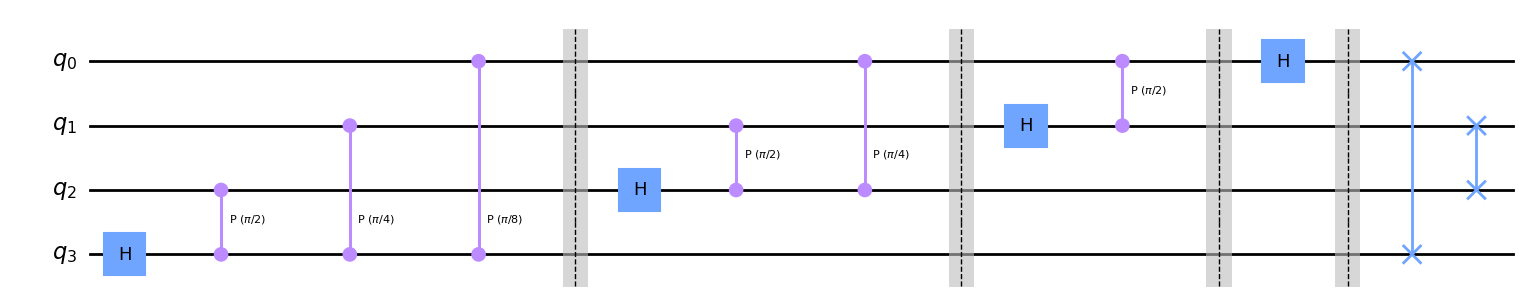

In [66]:
transpile(QFT(4,do_swaps=True,inverse=False,insert_barriers=True),simulator).draw('mpl')

### 3. Qiskit implementation

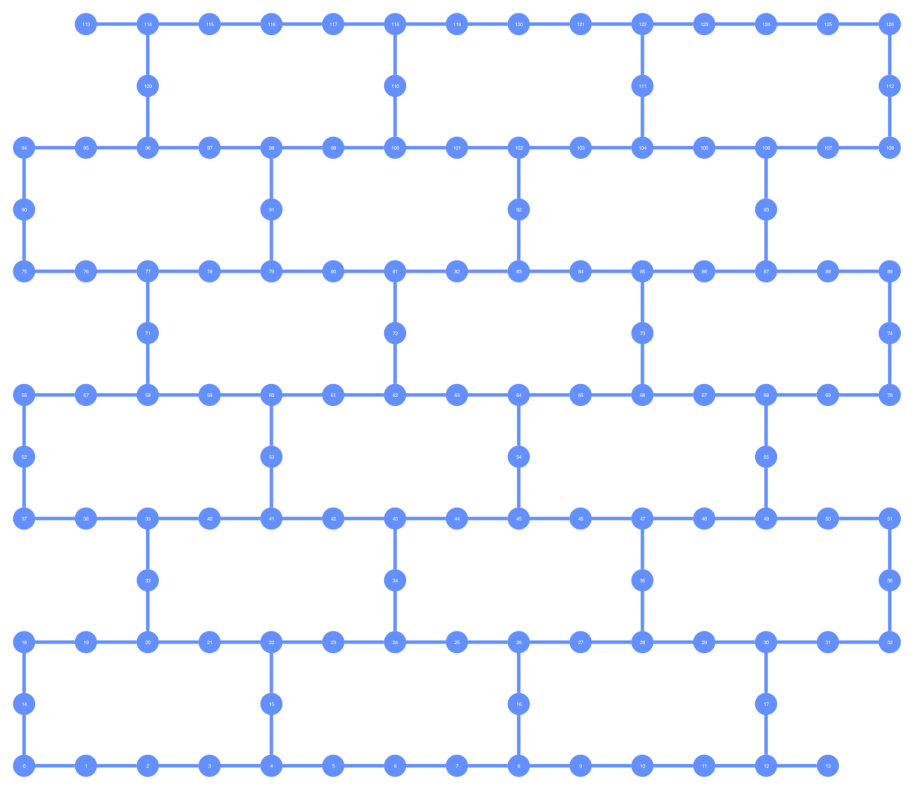

In [76]:
backend = provider.get_backend("ibm_brisbane")
plot_gate_map(backend,figsize=(16,10))


In [68]:
backendSimulator =  AerSimulator.from_backend(backend)

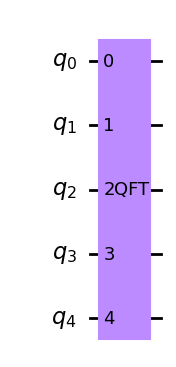

In [74]:
circuitQFT=QFT(5,do_swaps=True,inverse=False)
circuitQFT.draw('mpl')

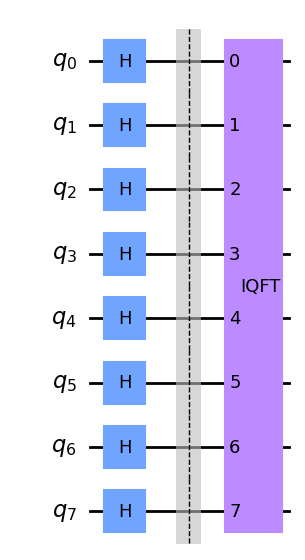

In [70]:
nQubit=8

qr = QuantumRegister(nQubit, 'q')
circuit = QuantumCircuit(qr,name=" QFT calculation")

#circuit.x(4)
for i in range(nQubit):
    circuit.h(i)
circuit.barrier()
circuit.append(QFT(nQubit,do_swaps=True,inverse=True),range(nQubit))

circuit.draw('mpl')

In [71]:
vector=Statevector(circuit)
display( vector.draw('latex') )

<IPython.core.display.Latex object>

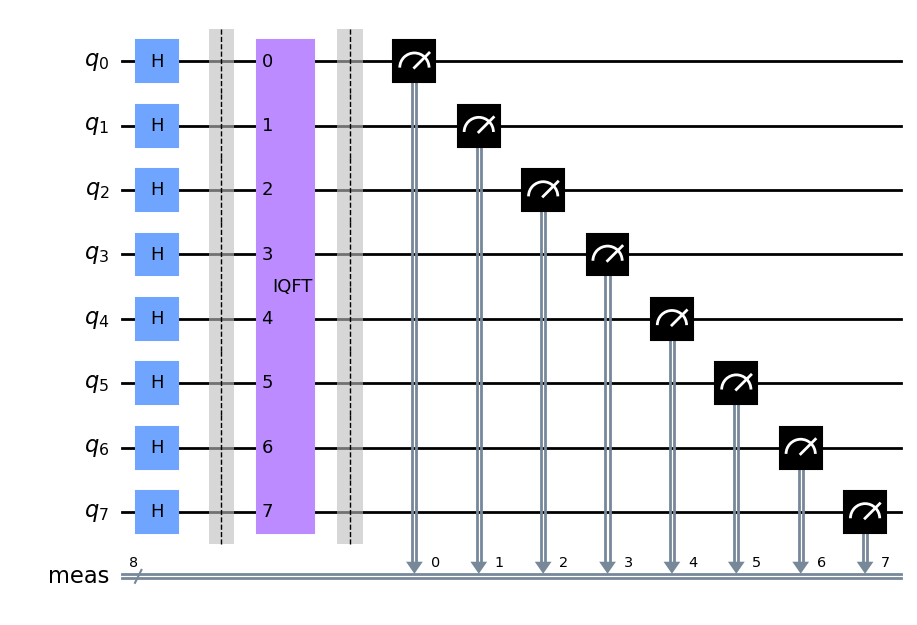

In [72]:
circuit.measure_all()
circuit.draw('mpl')

In [73]:
layout=[0,34,4,8,100,45,12,5]
circuitTranspiled=transpile(circuit,backendSimulator,initial_layout=layout,optimization_level=1)
#circuitTranspiled.draw('mpl')

In [82]:
# NON ESEGUIRE!!!!!
counts=backendSimulator.run(circuitTranspiled,shots=1000).result().get_counts()

: 

: 

In [77]:
layout=[0,1,2,3,4,5,6,7]
circuitTranspiled=transpile(circuit,backendSimulator,initial_layout=layout,optimization_level=1)
#circuitTranspiled.draw('mpl')

In [78]:
counts=backendSimulator.run(circuitTranspiled,shots=1000).result().get_counts()

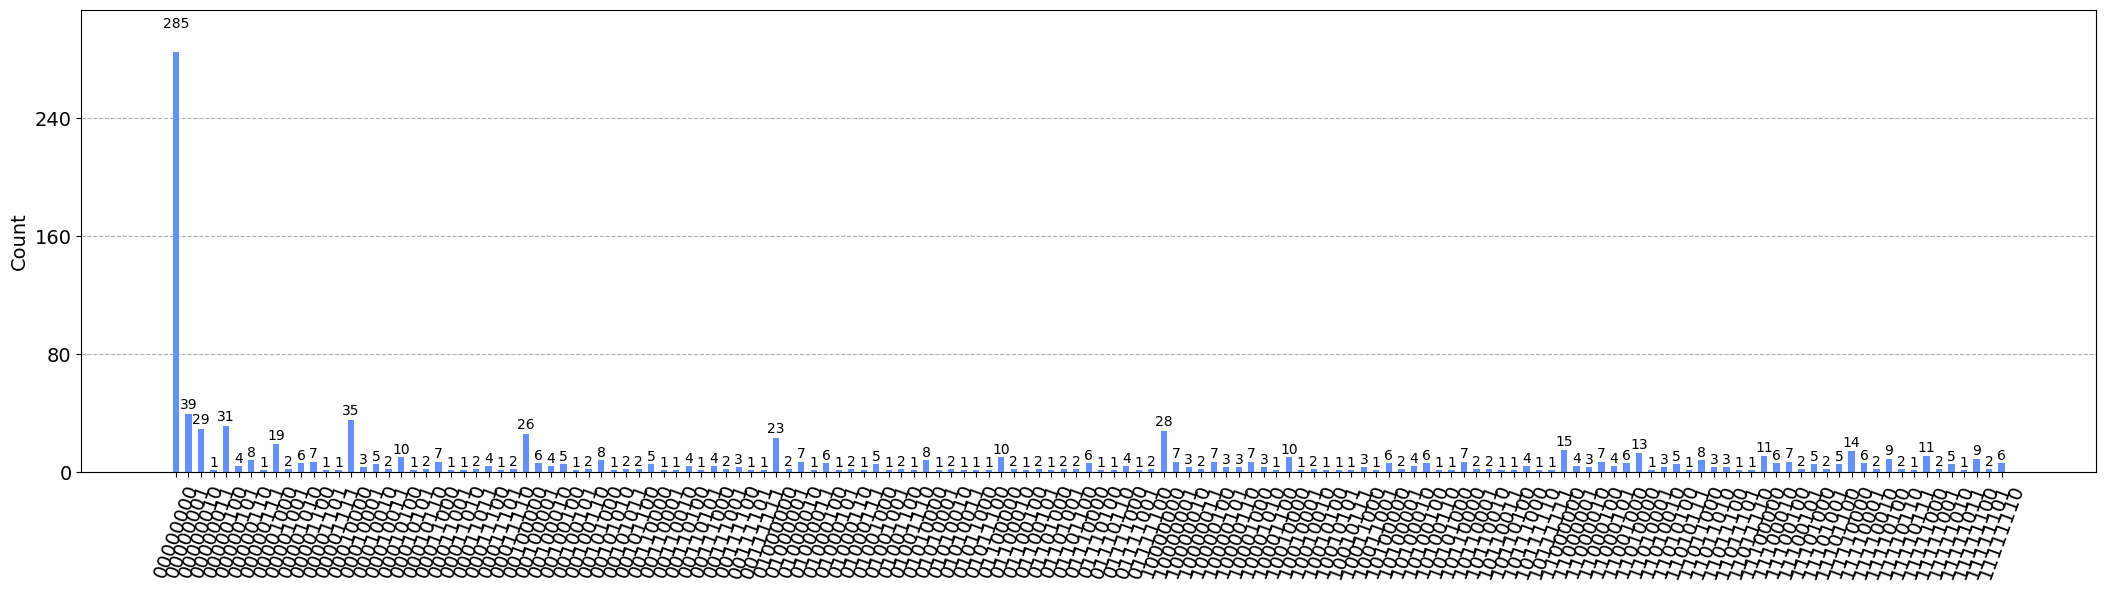

In [79]:
#display(counts)
plot_histogram(counts,figsize=(26,6))

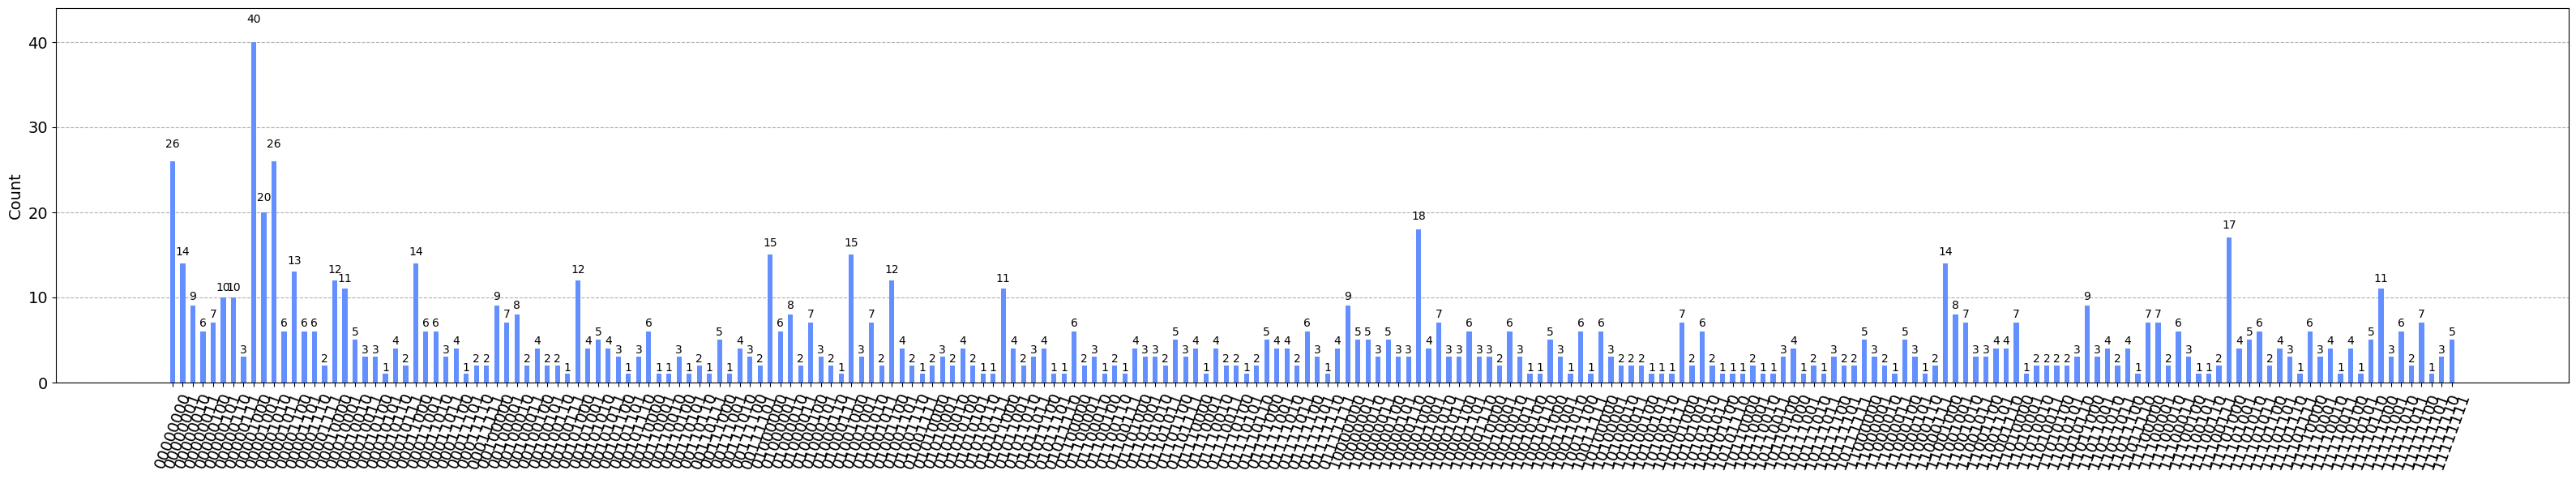

In [80]:
nQubit=8

qr = QuantumRegister(nQubit, 'q')
circuit = QuantumCircuit(qr,name=" QFT calculation")

circuit.x(3)
circuit.append(QFT(nQubit,do_swaps=False,inverse=False),range(nQubit))
circuit.barrier()
circuit.append(QFT(nQubit,do_swaps=False,inverse=True),range(nQubit))
circuit.barrier()
circuit.append(QFT(nQubit,do_swaps=False,inverse=False),range(nQubit))
circuit.barrier()
circuit.append(QFT(nQubit,do_swaps=False,inverse=True),range(nQubit))

circuit.measure_all()

layout=[0,1,2,3,4,5,6,7]
circuitTranspiled=transpile(circuit,backendSimulator,initial_layout=layout,optimization_level=1)
counts=backendSimulator.run(circuitTranspiled,shots=1000).result().get_counts()
plot_histogram(counts,figsize=(40,6))

# Variational algorithms

## Background


[Variational quantum algorithms](https://arxiv.org/abs/2012.09265) are promising candidate hybrid-algorithms for observing the utility of quantum computation on noisy near-term devices. Variational algorithms are characterized by the use of a classical optimization algorithm to iteratively update a parameterized trial solution, or "ansatz". Chief among these methods is the Variational Quantum Eigensolver (VQE) that aims to solve for the ground state of a given Hamiltonian represented as a linear combination of Pauli terms, with an ansatz circuit where the number of parameters to optimize over is polynomial in the number of qubits.  Given that size of the full solution vector is exponential in the number of qubits, successful minimization using VQE requires, in general, additional problem specific information to define the structure of the ansatz circuit.


Executing a VQE algorithm requires the following 3 components:

   1. Hamiltonian and ansatz (problem specification)
   2. Qiskit Runtime estimator
   3. Classical optimizer
   
Although the Hamiltonian and ansatz require domain specific knowledge to construct, these details are immaterial to the Runtime, and we can execute a wide class of VQE problems in the same manner. 

## Estimator 

Similar to the `Backend` base class, there is an `Estimator` base class defined in Qiskit Terra that standardizes the way users interact with all `Estimator` implementations.
This allows users to easily change their choice of simulator or device for performing expectation value calculations, even if the underlying implementation is different. 

In this section we will go over how to use Qiskit Runtime's implementation of the `Estimator` primitive.

### 1. Initialize the account

Since Qiskit Runtime `Estimator` is a managed service, you will first need to initialize your account. You can then select the simulator or real backend you want to use to calculate the expectation value.

Follow the steps in the [getting started guide](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/getting_started.html) if you don't already have an account set up.

In [81]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("ibmq_qasm_simulator")

### 2. Create a circuit

For a basic expectation value calculation you will need at least one quantum circuit to prepare our system in a precise quantum state for study. Our examples all have circuits in them, but you can use Qiskit to create your own. To learn how to create circuits by using Qiskit, see the [Circuit basics tutorial](https://qiskit.org/documentation/tutorials/circuits/01_circuit_basics.html).

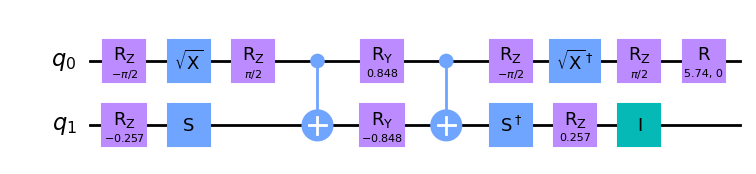

In [83]:
from qiskit.circuit.random import random_circuit
circuit = random_circuit(2, 2, seed=0).decompose(reps=1)
display(circuit.draw("mpl"))

### 3. Create an observable to measure

You will also need at least one observable to measure. Observables represent physical properties of a quantum system (such as energy or spin), and allow said properties to be measured (such as their expectation values) for a given state of our system. For simplicity, you can use the [SparsePauliOp class](https://qiskit.org/documentation/stubs/qiskit.quantum_info.SparsePauliOp.html#qiskit.quantum_info.SparsePauliOp) in Qiskit to define them, as illustrated in the following example.

In [86]:
from qiskit.quantum_info import SparsePauliOp
observable = SparsePauliOp("XZ")
print(f">>> Observable: {observable.paulis}")

>>> Observable: ['XZ']


### 4. Initialize the Qiskit Runtime Estimator

Here we are initializing an instance of `qiskit_ibm_runtime.Estimator` rather than `qiskit.primitives.Estimator` to use Qiskit Runtime's implementation of the `Estimator`. 

When you initialize the `Estimator`, you'll need to pass in the backend you previously selected as the target device (or simulator), using the `backend` parameter.

In [87]:
from qiskit_ibm_runtime import Estimator

estimator = Estimator(backend=backend)

### 5. Invoke the Estimator and get results

To calculate the expectation values, invoke the `run()` method of the `Estimator` instance you just created and pass in the circuit and observable as input parameters. This method call is asynchronous, and you will get a `Job` object back. You can use this object to query for information like `job_id()` and `status()`.

In [88]:
job = estimator.run(circuit, observable)

In [90]:
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: clbar95r12tet1q5a9n0
>>> Job Status: JobStatus.DONE


The `result()` method of the job will return the `EstimatorResult`, which includes both the expectation values and job metadata. 

In [91]:
result = job.result()
print(f">>> {result}")
print(f"  > Expectation value: {result.values[0]}")

>>> EstimatorResult(values=array([0.5]), metadata=[{'variance': 0.75, 'shots': 4000}])
  > Expectation value: 0.5


You can also provide compound inputs to the `run()` method:

In [92]:
circuits = (
    random_circuit(2, 2, seed=0).decompose(reps=1),
    random_circuit(2, 2, seed=1).decompose(reps=1),
)
observables = (
    SparsePauliOp("XZ"),
    SparsePauliOp("IY"),
)

job = estimator.run(circuits, observables)


In [94]:
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: clbarclr12tet1q5ab50
>>> Job Status: JobStatus.DONE


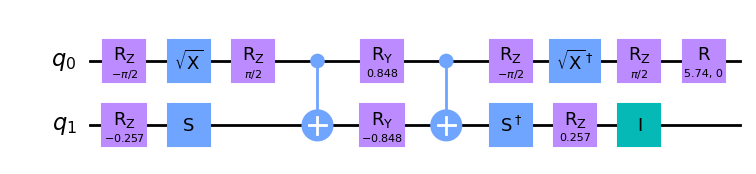

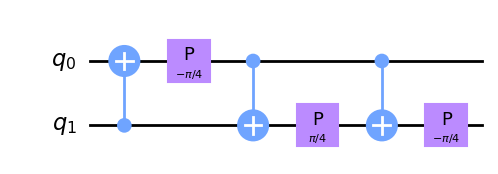

>>> Observables: [PauliList(['XZ']), PauliList(['IY'])]
>>> Expectation values: [0.5095, 0.011]


In [95]:
result = job.result()
[display(cir.draw("mpl")) for cir in circuits]
print(f">>> Observables: {[obs.paulis for obs in observables]}")
print(f">>> Expectation values: {result.values.tolist()}")

Or use parameterized circuits:

In [96]:
from qiskit.circuit.library import RealAmplitudes

circuit = RealAmplitudes(num_qubits=2, reps=2).decompose(reps=1)
observable = SparsePauliOp("ZI")
parameter_values = [0, 1, 2, 3, 4, 5]

job = estimator.run(circuit, observable, parameter_values)

In [97]:
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: clbargjk8l5ohotgpa80
>>> Job Status: JobStatus.DONE


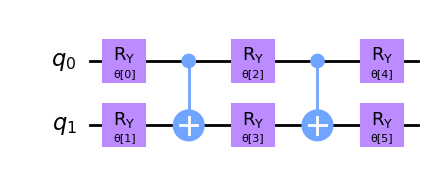

>>> Observable: ['ZI']
>>> Parameter values: [0, 1, 2, 3, 4, 5]
>>> Expectation value: -0.634


In [98]:

result = job.result()
display(circuit.draw("mpl"))
print(f">>> Observable: {observable.paulis}")
print(f">>> Parameter values: {parameter_values}")
print(f">>> Expectation value: {result.values[0]}")

## Example: Variational Quantum Eigensolver

### 1. Setup

Here we import the tools needed for a VQE experiment.  The primary imports can be grouped logically into three components that correspond to the three required elements.

In [99]:
# General imports
import time
import numpy as np

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# The IBM Qiskit Runtime / Primitives
#from qiskit_ibm_runtime import QiskitRuntimeService
#from qiskit_ibm_runtime import Estimator, Session
from qiskit.primitives import Estimator

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt



### 2. Problem specification


Here we define the problem instance for our VQE algorithm. Although the problem in question can come from a variety of domains, the form for execution through Runtime is the same. Qiskit provides a convenience class for expressing Hamiltonians in Pauli form, and a collection of widely used ansatz circuits in the `qiskit.circuit.library`.

Here, our example Hamiltonian is derived from a quantum chemistry problem

In [100]:
hamiltonian = SparsePauliOp.from_list(
    [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)]
)

and our choice of ansatz is the `EfficientSU2` that, by default, linearly entangles qubits, making it ideal for quantum hardware with limited connectivity.

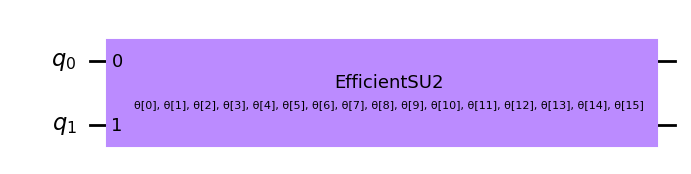

In [101]:
ansatz = EfficientSU2(hamiltonian.num_qubits)
ansatz.draw("mpl")

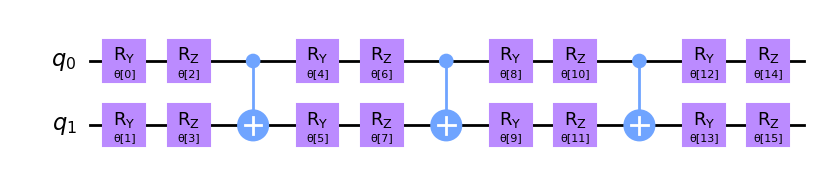

In [102]:
transpile(ansatz,simulator).draw('mpl')

In [103]:
num_params = ansatz.num_parameters
num_params

16

### 3. VQE cost function and minimization



Like many classical optimization problems, the solution to a VQE problem can be formulated as minimization of a scalar cost function.  By definition, VQE looks to find the ground state solution to a Hamiltonian by optimizing the ansatz circuit parameters to minimize the expectation value (energy) of the Hamiltonian.  With the Runtime `Estimator` directly taking a Hamiltonian and parameterized ansatz, and returning the necessary energy, The cost function for a VQE instance is quite simple:

In [104]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    energy = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return energy

Note that, in addition to the array of optimization parameters that must be the first argument, we use additional arguments to pass the terms needed in the cost function.

We are now free to use a classical optimizer of our choice to minimize our cost function. Here we use the [COBYLA routine from SciPy through the `minimize` function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html). Note that, when running on real quantum hardware, the choice of optimizer is important as not all optimizers handle noisy cost function landscapes equally well.

To begin the routine, we start by specifying a random initial set of parameters,

In [105]:
x0 = 2 * np.pi * np.random.random(num_params)

In [106]:
estimator = Estimator(options={"shots": int(1e4)})
res = minimize(cost_func, x0, args=(ansatz, hamiltonian, estimator), method="cobyla")

At the terminus of this routine we have a result in the standard SciPy `OptimizeResult` format.  From this we see that it took `nfev` number of cost function evaluations to obtain the solution vector of parameter angles (`x`) that, when plugged into the ansatz circuit, yield the approximate ground state solution we were looking for.

In [110]:
display(res)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.7029395591999044
       x: [ 6.635e+00  5.745e+00 ...  5.970e+00  4.709e+00]
    nfev: 197
   maxcv: 0.0

### 4. Adding a callback function


As it stands now, we are unable to save intermediate results from the iteration process, view the value of the cost function per iteration, nor are we able to monitor the progress of the routine.  Callback functions are a standard way for users to obtain additional information about the status of an iterative algorithm.  The standard SciPy callback routine allows for returning only the interim vector at each iteration.  However, it is possible to do much more than this.  Here we show how to use a mutable object, such as a dictionary, to store the current vector at each iteration, for example in case we need to restart the routine due to failure, and also return the current iteration number and average time per iteration.

In [119]:
def build_callback(ansatz, hamiltonian, estimator, callback_dict):
    """Return callback function that uses Estimator instance,
    and stores intermediate values into a dictionary.

    Parameters:
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance
        callback_dict (dict): Mutable dict for storing values

    Returns:
        Callable: Callback function object
    """

    def callback(current_vector):
        """Callback function storing previous solution vector,
        computing the intermediate cost value, and displaying number
        of completed iterations and average time per iteration.

        Values are stored in pre-defined 'callback_dict' dictionary.

        Parameters:
            current_vector (ndarray): Current vector of parameters
                                      returned by optimizer
        """
        # Keep track of the number of iterations
        callback_dict["iters"] += 1
        # Set the prev_vector to the latest one
        callback_dict["prev_vector"] = current_vector
        # Compute the value of the cost function at the current vector
        callback_dict["cost_history"].append(
            estimator.run(ansatz, hamiltonian, parameter_values=current_vector).result().values[0]
        )
        # Grab the current time
        current_time = time.perf_counter()
        # Find the total time of the execute (after the 1st iteration)
        if callback_dict["iters"] > 1:
            callback_dict["_total_time"] += current_time - callback_dict["_prev_time"]
        # Set the previous time to the current time
        callback_dict["_prev_time"] = current_time
        # Compute the average time per iteration and round it
        time_str = (
            round(callback_dict["_total_time"] / (callback_dict["iters"] - 1), 2)
            if callback_dict["_total_time"]
            else "-"
        )
        # Print to screen on single line
        print(
            "Iters. done: {} [Avg. time per iter: {}]".format(callback_dict["iters"], time_str),
            end="\r",
            flush=True,
        )

    return callback

We can now repeat the experiment setting the `callback` argument in `minimize` with our function:

In [120]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
    "_total_time": 0,
    "_prev_time": None,}

In [121]:
estimator = Estimator(options={"shots": int(1e4)})
callback = build_callback(ansatz, hamiltonian, estimator, callback_dict)
res = minimize(cost_func,x0,args=(ansatz, hamiltonian, estimator),method="cobyla",callback=callback)

If the procedure terminates correctly, then the `prev_vector` and `iters` values in our `callback_dict` dictionary should be equal to the solution vector and total number of function evaluations, respectively.  This is easy to verify:

In [122]:
all(callback_dict["prev_vector"] == res.x)

True

In [123]:
callback_dict["iters"] == res.nfev

True

We can also now view the progress towards convergence as monitored by the cost history at each iteration:

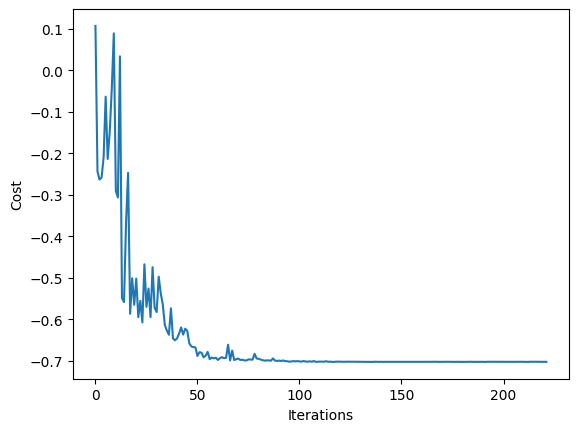

In [124]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost");

## Example: Variational Quantum Classifier

### 1. Setup

Here we import the tools needed for a VQC experiment. 

In [4]:
# General imports
import time
import numpy as np

# The IBM Qiskit Runtime / Primitives
from qiskit.primitives import Sampler

# SciPy minimizer routine
from scipy.optimize import minimize

# Datasets
from sklearn.datasets import make_moons

# Plotting functions
import matplotlib.pyplot as plt


### 2. Problem specification

Before we dive into solving the question it is always beneficial to look at the dataset pictographically. This will help us understand patterns which we could leverage when designing our feature maps and variational circuits for example.

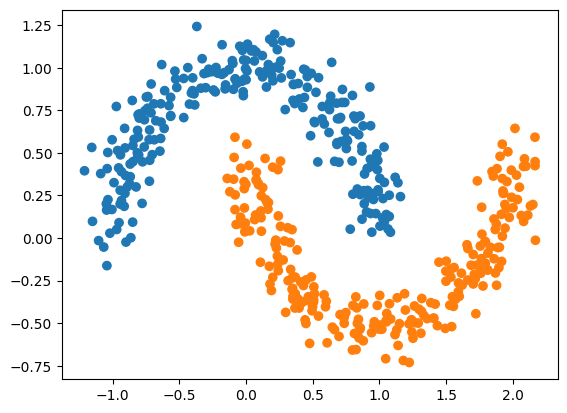

In [5]:
# Set random seeds
np.random.seed(42)

# number of samples
N=500

# Let's use the Moons dataset
X, Y = make_moons(n_samples=N, noise=0.1)

c = ["#1f77b4" if y_ == 0 else "#ff7f0e" for y_ in Y]  # colours for each class
#plt.axis("off")
plt.scatter(X[:, 0], X[:, 1], c=c)
plt.show()

In [6]:
display(X,Y)

array([[ 8.30676427e-01, -4.09935810e-01],
       [ 7.98355288e-01,  8.37612175e-01],
       [ 1.05046846e+00, -4.85161929e-01],
       [-2.58142758e-01,  9.80008438e-01],
       [ 3.30681598e-01,  1.14763307e+00],
       [ 1.26625226e+00, -4.96983608e-01],
       [ 1.07616580e+00, -3.85878358e-01],
       [ 5.64510528e-02,  1.10604396e+00],
       [ 5.87095987e-01,  6.69691770e-01],
       [ 1.76040471e+00, -2.06327891e-01],
       [ 1.00458991e+00,  7.03051390e-02],
       [-6.45719841e-01,  5.10437812e-01],
       [ 1.54254256e+00, -5.20178637e-01],
       [ 3.65210907e-01,  7.89799595e-01],
       [ 1.15098343e+00, -5.03033666e-01],
       [ 1.22244849e+00, -5.03918512e-01],
       [ 1.98971893e+00,  3.98966063e-01],
       [ 9.34292468e-01,  4.18991820e-01],
       [ 4.94958027e-01, -4.27205339e-01],
       [ 1.57127357e+00, -3.59203356e-01],
       [ 1.95678367e+00,  3.31919974e-01],
       [ 2.09927798e+00,  4.22134447e-01],
       [-8.26245842e-02,  1.66775129e-01],
       [ 8.

array([1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,

### 3. Ansatz

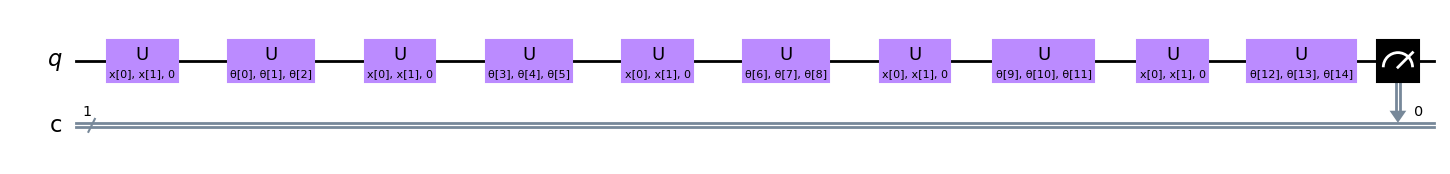

In [12]:

from qiskit.circuit import ParameterVector

# data re-uploading classifier circuit

L=5

x=ParameterVector('x',2)
thetas = ParameterVector('θ',3*L)

qr = QuantumRegister(1, name="q")
cr = ClassicalRegister(1, name='c')
ansatz = QuantumCircuit(qr, cr)
for k in range(L):
    ansatz.u(x[0],x[1],0.0,qr)
    ansatz.u(thetas[3*k+0], thetas[3*k+1], thetas[3*k+2], qr) # su(2) rotation
ansatz.measure(qr, cr)
ansatz.draw('mpl')

In [13]:
num_params = ansatz.num_parameters
display(num_params)

17

### 4. VQC cost function and minimization

In [21]:
params0 = 2 * np.pi * np.random.random(3*L)

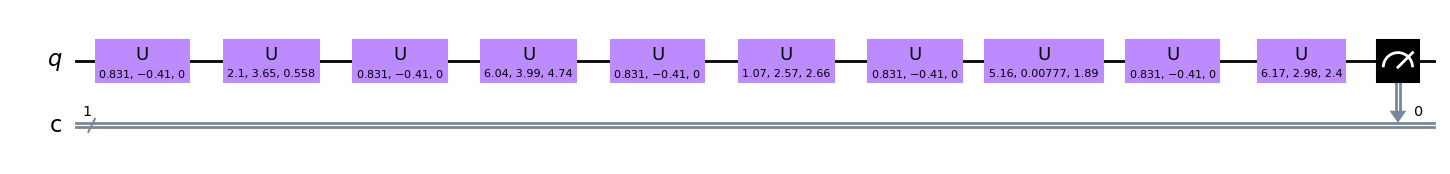

In [22]:
circuit=ansatz.assign_parameters({x:X[0], thetas:params0})
circuit.draw('mpl')

In [23]:
sampler=Sampler()

In [24]:
def loss(params, ansatz, x , y , sampler):
    """Return the loss for a pattern 

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        x (numpyArray): Array of the pattern features
        y (integer): Class of the pattern 0 or 1
        sampler (Estimator): Sampler primitive instance

    Returns:
        float: loss function (cost function)
    """
    parameter_values=np.concatenate((x,params))
    job = sampler.run(ansatz, parameter_values=parameter_values)
    loss = 1 - job.result().quasi_dists[0].get(y)
    return loss

In [25]:
def cost_func( params, ansatz, trainingX , trainingY , sampler):
    N=len(trainingY)
    return sum(loss(params,ansatz,trainingX[k],trainingY[k],sampler) for k in range(N))/N

In [26]:
def predict(params,x,ansatz,sampler):
    if loss(params,ansatz,x,0,sampler) < 0.5:
        return 0
    else:
        return 1

In [27]:
cost_func(params0,ansatz,X,Y,sampler)

0.6303385779851944

Check the classifier's prediction before the training

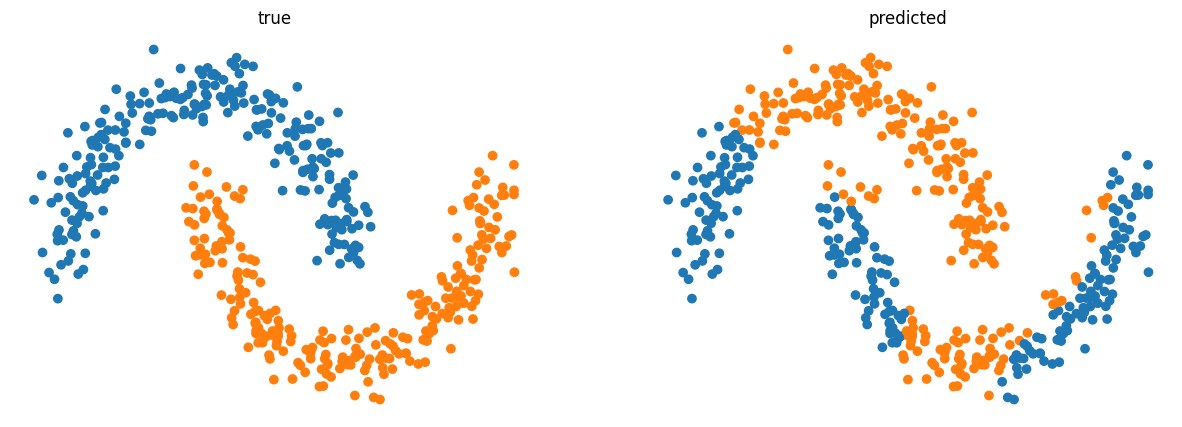

In [28]:
Ypred = [predict(params0,x,ansatz,sampler) for x in X]
c = ["#1f77b4" if y == 0 else "#ff7f0e" for y in Y]  # colours for each class
cpred = ["#1f77b4" if y == 0 else "#ff7f0e" for y in Ypred]  # colours for each class
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("true")
plt.scatter(X[:, 0], X[:, 1], c=c)
plt.subplot(1,2,2)
plt.axis("off")
plt.title("predicted")
plt.scatter(X[:, 0], X[:, 1], c=cpred)
plt.show()

In [29]:
trainingX=X[0:100]
trainingY=Y[0:100]
res = minimize(cost_func, params0, args=(ansatz, trainingX , trainingY , sampler), method="cobyla")

In [30]:
res.fun


0.07389113350821179

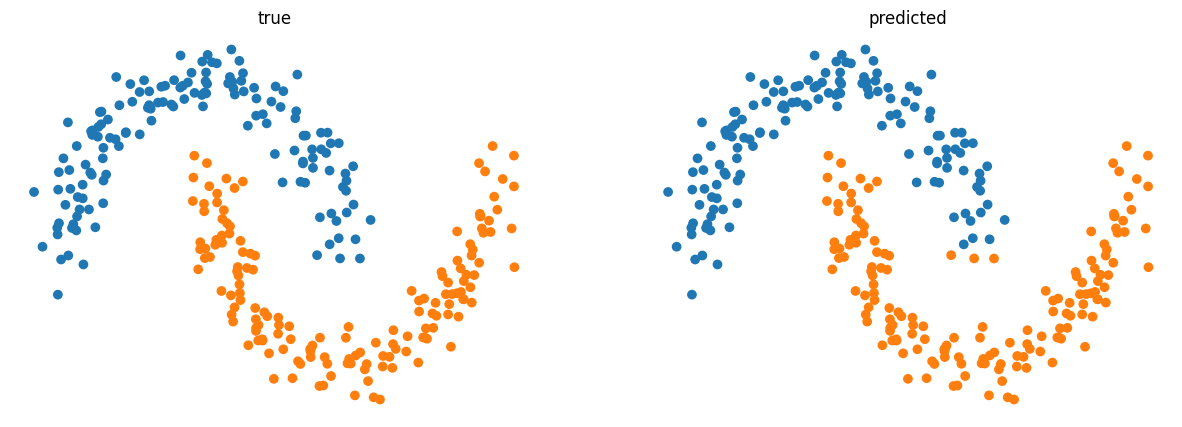

In [31]:
paramsOpt=res.x
Ypred = [predict(paramsOpt,x,ansatz,sampler) for x in X[200:]]
c = ["#1f77b4" if y == 0 else "#ff7f0e" for y in Y[200:]]  # colours for each class
cpred = ["#1f77b4" if y == 0 else "#ff7f0e" for y in Ypred]  # colours for each class
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("true")
plt.scatter(X[200:, 0], X[200:, 1], c=c)
plt.subplot(1,2,2)
plt.axis("off")
plt.title("predicted")
plt.scatter(X[200:, 0], X[200:, 1], c=cpred)
plt.show()

Let's plot the points on the `Bloch` sphere (Python Qutip library is needed to compile the following code):

In [32]:
from qutip import basis,Bloch, expect, sigmax,sigmay,sigmaz
#import qutip as qt
L=5
x=ParameterVector('x',2)
thetas = ParameterVector('θ',3*L)
qr = QuantumRegister(1, name="q")
cr = ClassicalRegister(1, name='c')
qc = QuantumCircuit(qr, cr)
for k in range(L):
    qc.u(x[0],x[1],0.0,qr)
    qc.u(thetas[3*k+0], thetas[3*k+1], thetas[3*k+2], qr) # su(2) rotation


def blochPoints(X,Y,params,ansatz):
    xp1=[]
    yp1=[]
    zp1=[]

    xp0=[]
    yp0=[]
    zp0=[]

    for i in range(len(X)):
        circuit=ansatz.assign_parameters({x:X[i], thetas:params})
        state=Statevector(circuit)
  
        pnt=state[0]*basis(2,0)+state[1]*basis(2,1)
        if Y[i]==0:
            xp0.append(expect(sigmax(),pnt))
            yp0.append(expect(sigmay(),pnt))
            zp0.append(expect(sigmaz(),pnt))
        else:
            xp1.append(expect(sigmax(),pnt))
            yp1.append(expect(sigmay(),pnt))
            zp1.append(expect(sigmaz(),pnt))
    return [[xp0,yp0,zp0],[xp1,yp1,zp1]]


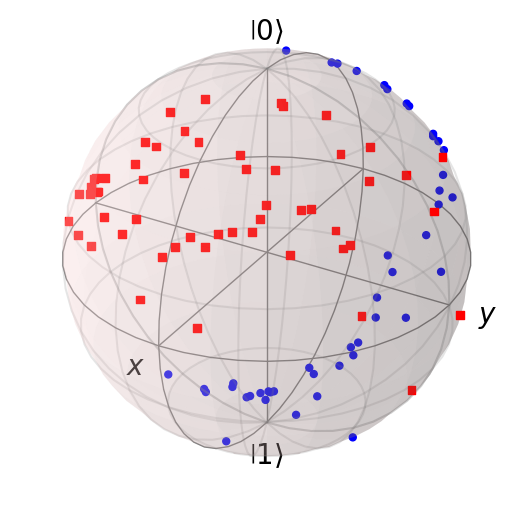

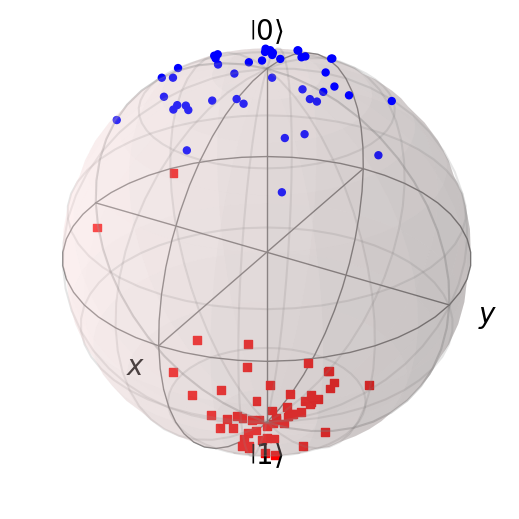

In [34]:
b1=Bloch()
b2=Bloch()

b1.add_points(blochPoints(X[200:300],Y[200:300],params0,qc)[0])
b1.add_points(blochPoints(X[200:300],Y[200:300],params0,qc)[1])

b2.add_points(blochPoints(X[200:300],Y[200:300],paramsOpt,qc)[0])
b2.add_points(blochPoints(X[200:300],Y[200:300],paramsOpt,qc)[1])

b1.show()
b2.show()


# Copyright

In [35]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright